In [1]:
import tensorflow as tf
import os

from tensorflow import keras
import pandas as pd
import numpy as np
import math
import datetime
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# import tensorflow_model_optimization as tfmot
# import tf_keras as keras

from tensorflow.python.summary.summary_iterator import summary_iterator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-04-26 08:16:14.498485: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-26 08:16:15.072746: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 08:16:17.216517: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model = tf.keras.models.load_model("model_pretune.keras")

2024-04-26 08:16:21.558726: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-04-26 08:16:21.558869: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: kim-HP-Pavilion-Laptop-14-dv0xxx
2024-04-26 08:16:21.558879: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: kim-HP-Pavilion-Laptop-14-dv0xxx
2024-04-26 08:16:21.559111: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 535.171.4
2024-04-26 08:16:21.559136: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 535.171.4
2024-04-26 08:16:21.559143: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 535.171.4
/home/kim/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping var

In [3]:
model.summary()

Model: "train-head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ universal_input (InputLayer)    │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resize (Resizing)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_13 (TrueDivide)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_13 (Subtract)          │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ base_model (Functional)         │ (None, 14, 14, 512)    │       821,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_extraction (Sequential)   │ (None, 2, 2, 256)      │       272,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pre_classification (Sequential) │ (None, 32)             │         8,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head (Dense)     │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,383,378 (5.28 MB)

 Trainable params: 280,680 (1.07 MB)

 Non-trainable params: 822,016 (3.14 MB)

 Optimizer params: 280,682 (1.07 MB)

In [4]:
def load_data():
    x = pd.read_csv('datasets/fer2013.csv')

    train_set = x[(x.Usage == 'Training')]
    validation_set = x[(x.Usage == 'PublicTest')]
    test_set = x[(x.Usage == 'PrivateTest')]

    depth = 1
    height = int(math.sqrt(len(x.pixels[0].split())))
    width = height

    X_train = np.array(list(map(str.split, train_set.pixels)), np.float32)
    X_valid = np.array(list(map(str.split, validation_set.pixels)), np.float32)
    X_test = np.array(list(map(str.split, test_set.pixels)), np.float32)

    num_train = X_train.shape[0]
    num_validation = X_valid.shape[0]
    num_test = X_test.shape[0]

    X_train = X_train.reshape(num_train, width, height, depth)
    X_valid = X_valid.reshape(num_validation, width, height, depth)
    X_test = X_test.reshape(num_test, width, height, depth)

    def grayscale_to_rgb(images):
        # Repeat the single-channel grayscale image across three channels
        return np.repeat(images, 3, axis=-1)

    X_train = grayscale_to_rgb(X_train)
    X_valid = grayscale_to_rgb(X_valid)
    X_test = grayscale_to_rgb(X_test)

    y_train = train_set.emotion
    y_valid = validation_set.emotion
    y_test = test_set.emotion

    return X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_valid, y_valid, X_test, y_test = load_data()

In [5]:
def compute_model_size(model):
    # Initialize total size
    total_size = 0

    # Iterate through all model parameters
    for layer in model.layers:
        params = layer.get_weights()
        if params:
            for param in params:
                # Calculate size of each parameter
                param_size = np.prod(param.shape) * param.dtype.itemsize
                total_size += param_size

    # Convert total size to megabytes
    total_size_mb = total_size / (1024 * 1024)

    return total_size_mb

# Example usage:
model_size_mb = compute_model_size(model)
print("Model size: {:.2f} MB".format(model_size_mb))

Model size: 4.21 MB


In [6]:
test_loss, test_acc = model.evaluate(X_test, y_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 496ms/step - accuracy: 0.6222 - loss: 1.0535


113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 499ms/step


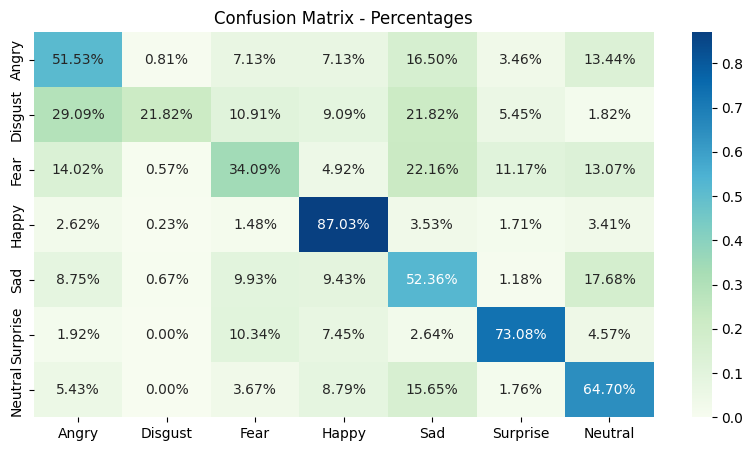

In [7]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=-1)

cm_array = confusion_matrix(y_test, y_pred,
                            normalize='true')

# labels of the confusion matrix
cm_labels = ["Angry", "Disgust", "Fear", "Happy",
             "Sad", "Surprise", "Neutral"]

# create data frame of confusion matrix and labels
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

# plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percentages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

In [8]:
# for event in summary_iterator('/home/kim/Documents/Scriptie/code/logs/fit/20240422-204620/train/events.out.tfevents.1713811656.kim-HP-Pavilion-Laptop-14-dv0xxx.5103.7.v2'):
#     for value in event.summary.value:
#         print(value.tag)
#         if value.HasField('simple_value'):
#             print(value.simple_value)

In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

AttributeError: 'Functional' object has no attribute '_get_save_spec'

In [ ]:
import tensorflow_model_optimization as tfmot
import tf_keras as keras


def apply_quantization_to_layer(layer):
  if isinstance(layer, keras.layers.Dense):
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer


annotated_layers = []
for layer in model.layers:
    
    annotated_layers.append(layer)

# Create a new model using the annotated layers
# annotated_model = tf.keras.Sequential(annotated_layers)

annotated_model = keras.models.clone_model(
    model,
    clone_function=apply_quantization_to_layer,
)

# # Now that the Dense layers are annotated,
# # `quantize_apply` actually makes the model quantization aware.
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()


In [ ]:
annotated_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
annotated_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resize (Resizing)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ base_model (Functional)         │ (None, 7, 7, 960)      │       870,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_extraction (Sequential)   │ (None, 1, 1, 256)      │       393,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pre_classification (Sequential) │ (None, 32)             │         8,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head (Dense)     │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,272,711 (4.86 MB)

 Trainable params: 402,503 (1.54 MB)

 Non-trainable params: 870,208 (3.32 MB)